# Sanity check FLCT vs Stein simulation vs HMI data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter 

In [43]:
def read_vel(file, data_str):
    idl_dict = readsav(file)
    vel = idl_dict[data_str]
    return vel

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy

datadir = '/Users/rattie/Data/Karin/sanity_check/'

rsun_obs=953.288 # arcsec
# SDO resolution
# Arcsec/pix
cdelt1=0.504365
# R -> m
rsun_ref=6.96000e8
# R -> km
rkm=rsun_ref/1000.0
# R -> pixel
rsun=round(rsun_obs/cdelt1)
# Nb. m / pix
deltas = rkm*1e3/rsun_obs*cdelt1
print(deltas)
unit = deltas / 60 # m/s

# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]
fwhm = 7

368239.23095643707


### 1) Load FLCT results (Karin) on drifted series

In [85]:
flctfiles_stein = sorted(glob.glob(os.path.join(datadir, 'Stein-simulation-series', 'drift_*/flct-km*.save')))
flctfiles_hmi = sorted(glob.glob(os.path.join(datadir, 'hmi_series', 'flct-km*.save')))

print('Stein-drifted data')
for f in flctfiles_stein:
    print(f)
print('HMI drifted data')
for f in flctfiles_hmi:
    print(f)
# Load IDL save files
vxs_flct_stein = [read_vel(f, 'vx')*unit for f in flctfiles_stein]
vxs_flct_hmi = [read_vel(f, 'vx') for f in flctfiles_hmi]
print(vxs_flct_stein[0].shape)
print(vxs_flct_hmi[0].shape)

# FLCT results on unfiltered hmi 
# flctfiles_hmi_unfiltered_vx = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/hmi_series_FLCT_1011/output_FLCT_sigma7', 
#                                                          'drift_unfiltered_*/FLCT_vx1_000-038.fits')))
flctfiles_hmi_unfiltered_vx = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/hmi_series_FLCT_1011/output_FLCT_sigma7', 
                                                         'drift_unfiltered_*/FLCT_vx1_000-038.fits')))
# Load unfiltered files (FLCT run by me)
vxs_flct_hmi_unfiltered = [fitsio.read(f) for f in flctfiles_hmi_unfiltered_vx]

Stein-drifted data
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_00/flct-km-Stein-simul-drift_00-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_01/flct-km-Stein-simul-drift_01-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_02/flct-km-Stein-simul-drift_02-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_03/flct-km-Stein-simul-drift_03-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_04/flct-km-Stein-simul-drift_04-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_05/flct-km-Stein-simul-drift_05-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_06/flct-km-Stein-simul-drift_06-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulation-series/drift_07/flct-km-Stein-simul-drift_07-dt1-dx7pix.save
/Users/rattie/Data/Karin/sanity_check/Stein-simulatio

#### Load true Stein velocity field

In [86]:
data_dir_stein = '/Users/rattie/Data/Ben/SteinSDO/'
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
trange = [0,29]
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)

# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein[fov].mean()
print(vx_stein_mean, 'm/s')


-90.40378 m/s


In [87]:
dv = 0.04
vx_rates = np.arange(-0.2, 0.21, dv)
vx_rates[int(len(vx_rates)/2)] = 0
vx_ratesu = vx_rates*unit
print(vx_rates)
print(vx_ratesu.round())

[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2 ]
[-1227.  -982.  -736.  -491.  -245.     0.   245.   491.   736.   982.
  1227.]


In [88]:
# Average FLCT on Stein with time range of 30 min. 29 velocity fields for Stein. 
vxsmean_flct_stein = np.array([vx[0:29,10:-10,10:-10].mean(axis=0).mean() - vx_stein_mean for vx in vxs_flct_stein])
print(vxsmean_flct_stein[5])
# padding for hmi
pad2 = 24
# Average FLCT on HMI with time range of 30 min. 39 frames for HMI
vxsmean_flct_hmi = np.array([vx[0:39,pad2:-pad2,pad2:-pad2].mean(axis=0).mean()  for vx in vxs_flct_hmi])
vxsmean_flct_hmi_unfiltered = np.array([vx[pad2:-pad2,pad2:-pad2].mean() for vx in vxs_flct_hmi_unfiltered])

38.111614


### Linear fit of FLCT results on Stein simulation drifted data

In [89]:
x1 = vxsmean_flct_stein
y1 = vx_ratesu
A1 = np.vstack([x1, np.ones(len(x1))]).T
fit = np.linalg.lstsq(A1, y1, rcond=None)
m1, c1 = fit[0]
residuals1 = fit[1]
print(m1, c1)
vxfit1 = m1*x1 + c1

1.201451380446586 -43.76518303521126


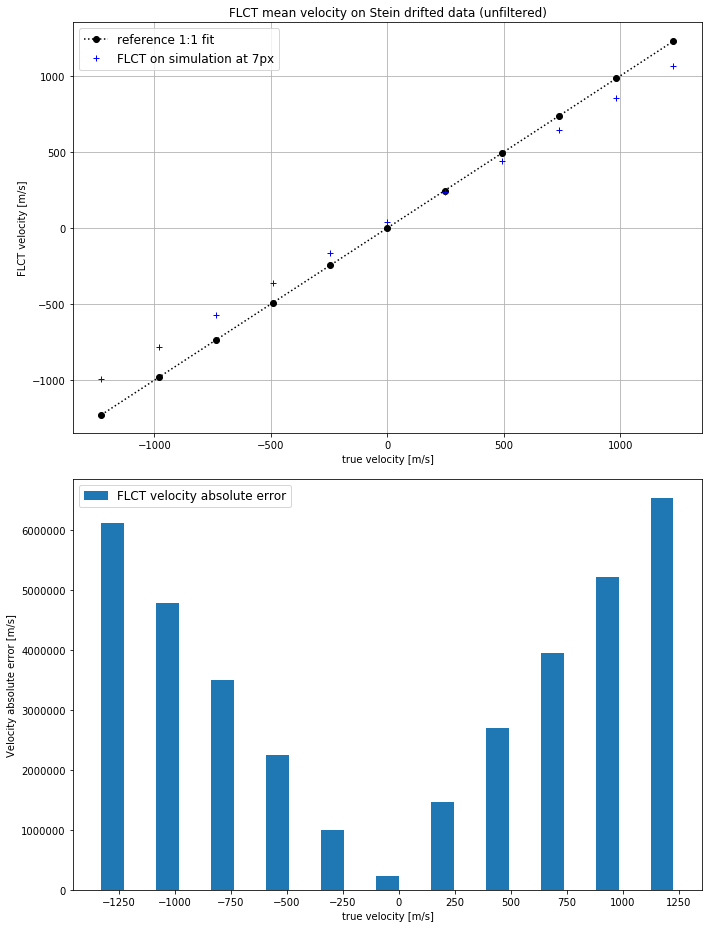

In [95]:
%matplotlib inline
FS = 12
fig, ax = plt.subplots(2,1, figsize = (10,13))
ax[0].plot(vx_ratesu, vx_ratesu, ls=':', marker='o', color='black', label='reference 1:1 fit')
ax[0].plot(vx_ratesu, vxsmean_flct_stein, ls='none', marker='+', color='blue', label = 'FLCT on simulation at 7px')
#ax[0].plot(vx_ratesu, vxfit1, ls='-', color='blue', label = 'FLCT on simulation at 7px (fit)')

#ax[0].plot(vx_ratesu, vxfit, marker='o', label = 'FLCT fit [ {:1.1f}, {:1.0f} ]'.format(m, c))
#ax.plot(vx_rates*unit, vxsmean_flct_hmi*unit, marker='+', label = 'FLCT on HMI at 7px')
ax[0].grid(True, axis='both')
ax[0].set_xlabel('true velocity [m/s]')
ax[0].set_ylabel('FLCT velocity [m/s]')
ax[0].legend(prop={'size': FS})
ax[0].set_title('FLCT mean velocity on Stein drifted data (unfiltered)')

# Residuals before and after fit
res1 = abs((vxsmean_flct_stein*unit- vx_stein_mean) - vx_rates*unit)
res2 = abs(vxfit1 - y1)

# width of the bars 
bw = 100
ax[1].bar(vx_ratesu-bw/2, res1, bw, label='FLCT velocity absolute error')
#ax[1].bar(vx_ratesu+bw/2, res2, bw, label='FLCT velocity absolute error (after fit)')
ax[1].set_xlabel('true velocity [m/s]')
ax[1].set_ylabel('Velocity absolute error [m/s]')
ax[1].legend(prop={'size': FS})
ax[1].set_xticks(np.arange(-1250, 1251, 250))
plt.tight_layout()

### Linear fit of FLCT results on HMI drifted data

In [91]:
unit2 = deltas / 45 # m/s 
vx_ratesu2 = vx_rates*unit2

# Filtered data (filtered by Karin)
x2 = vxsmean_flct_hmi*unit2
y2 = vx_ratesu2
A2 = np.vstack([x2, np.ones(len(x2))]).T
fit = np.linalg.lstsq(A2, y2, rcond=None)
m2, c2 = fit[0]
residuals2 = fit[1]
print('bias velocity (filtered) =', c2, 'm/s')
vxfit2 = m2*x2 + c2

bias velocity (filtered) = 11.645295789006024 m/s


In [92]:
# Unfiltered data (run by me)
x3 = vxsmean_flct_hmi_unfiltered*unit2
y3 = vx_ratesu2
A3 = np.vstack([x3, np.ones(len(x3))]).T
fit = np.linalg.lstsq(A3, y3, rcond=None)
m3, c3 = fit[0]
residuals3 = fit[1]
print('bias velocity (unfiltered) =', c3, 'm/s')
vxfit3 = m3*x3 + c3

bias velocity (unfiltered) = -19.773294386970033 m/s


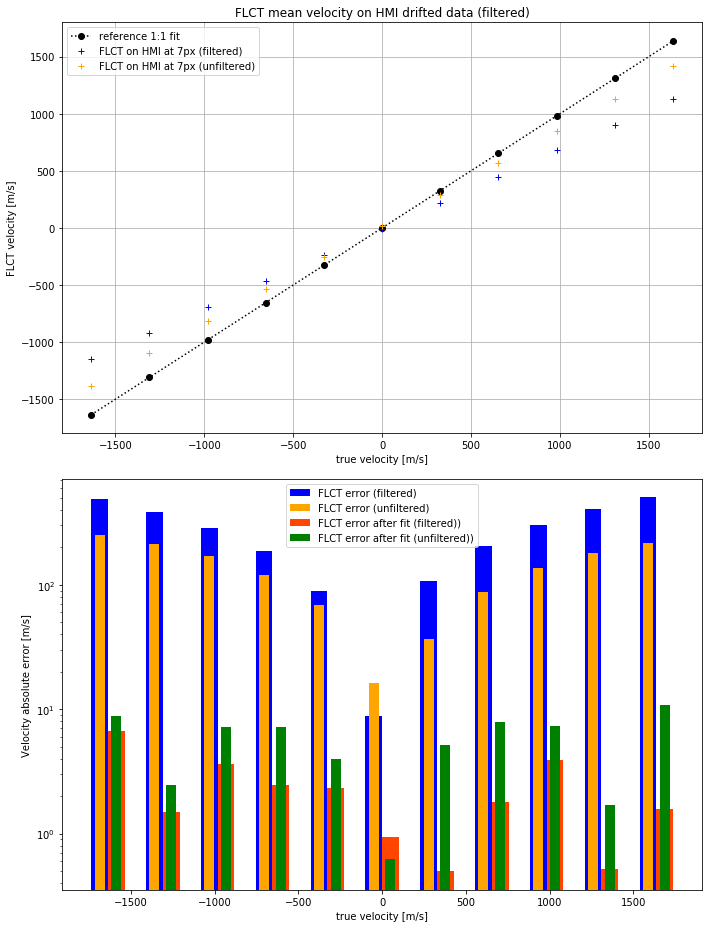

In [93]:
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize = (10,13))
ax[0].plot(vx_ratesu2, vx_ratesu2, 'k-', ls=':', marker='o', label='reference 1:1 fit')
ax[0].plot(vx_ratesu2, vxsmean_flct_hmi*unit2, ls='none', marker='+', color='blue', label = 'FLCT on HMI at 7px (filtered)')
ax[0].plot(vx_ratesu2, vxsmean_flct_hmi_unfiltered*unit2, ls='none', marker='+', color='orange', label = 'FLCT on HMI at 7px (unfiltered)')
ax[0].grid(True, axis='both')
ax[0].set_xlabel('true velocity [m/s]')
ax[0].set_ylabel('FLCT velocity [m/s]')
ax[0].legend()
ax[0].set_title('FLCT mean velocity on HMI drifted data (filtered)')

# Residuals before and after fit
res1_filtered = abs(vxsmean_flct_hmi*unit2 - vx_ratesu2)
res2_filtered = abs(vxfit2 - y2)

res1_unfiltered = abs(vxsmean_flct_hmi_unfiltered*unit2 - vx_ratesu2)
res2_unfiltered = abs(vxfit3 - y3)

# width of the bars 
bw = 100
ax[1].bar(vx_ratesu2-bw/2, res1_filtered, bw, color='blue', label='FLCT error (filtered)')
ax[1].bar(vx_ratesu2-bw/2, res1_unfiltered, 0.6*bw, color='orange', label='FLCT error (unfiltered)')
ax[1].bar(vx_ratesu2+bw/2, res2_filtered, bw, color='orangered', label='FLCT error after fit (filtered))')
ax[1].bar(vx_ratesu2+bw/2, res2_unfiltered, 0.6*bw, color='green', label='FLCT error after fit (unfiltered))')
ax[1].set_xlabel('true velocity [m/s]')
ax[1].set_ylabel('Velocity absolute error [m/s]')
ax[1].legend()
ax[1].set_yscale('log')
#ax[1].set_xticks(np.arange(-1800, 1801, 500))
plt.tight_layout()

### 2) Correlation between velocites from FLCT and Stein MHD simulation (no drift)

In [13]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2



#### Smooth Stein MHD velocity to be comparable to FLCT velocity

In [14]:
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='boxcar') 

#### Load FLCT velocity (zero drift) - Karin

In [15]:
# Index in velocity series where drift is zero
vx_flct = fitsio.read('/Users/rattie/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma7/FLCT_vx1_000-028.fits')
vy_flct = fitsio.read('/Users/rattie/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma7/FLCT_vy1_000-028.fits')

#### Compute correlation

In [16]:
c_pearsons = calc_c_pearson(vx_stein_sm, vx_flct, vy_stein_sm, vy_flct, fov=fov) 
print(c_pearsons)

0.8544049358259741
